# example notebook: receptive fields

This example notebook runs the receptive field functionality in jupyter notebook format, instead of on the RF-Explorer GUI.

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

## load neural data

Let's look at the neural data of mice responding to textures.

 Let's first examine the original sample_neural_data.npz file to understand the data format.

In [2]:
# examine raw neural data
neural_path = "../sample_data/sample_neural_data.npz"
examine_data = np.load(neural_path, allow_pickle=True)
for k in examine_data.keys():
    print(k, examine_data[k].shape)

istim (13860,)
frame_start (13860,)
ypos (100,)
xpos (100,)
fspont (2081,)
spks (100, 29800)


The raw data is in a dictionary with the following keys, each containing a matrix: 'istim', 'frame_start', 'xpos', 'ypos', 'fspont', and 'spks.''istim' is the stimuli identifier, frame_start is the time at which frame is shown, 'xpos' and 'ypos' are the spatial coordinates of that cell, 'fspont' is spontaneous activity (and optional for this analysis), and 'spks' is the neural activity in a neuron x timepoint matrix.

Here, after preprocessing, we will have 100 neurons at 13860 timepoints. 

Now let's load the file path using our process_neural_data function, which processes and z-scores our data. 

In [3]:
from utils import process_neural_data
# process and load neural data
spks, istim, xpos, ypos = process_neural_data(neural_path)

load data done!
spks shape:  (100, 13860)
istim shape:  (13860,)


Let's plot a neural trace of one neuron for the first 400 timepoints.

Text(0, 0.5, 'neural response')

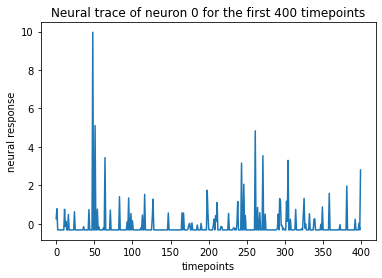

In [4]:
plt.figure()
plt.plot(spks[0,:400])
plt.title("Neural trace of neuron 0 for the first 400 timepoints")
plt.xlabel('timepoints')
plt.ylabel('neural response')

## load stimuli data

When loading our stimuli data, we have two options: we can either load preprocessed data, or process the data with our functionality:

<!-- **load_stim_data**: Takes a path to a .mat file containing a dictionary with an 'img' key. The 'img' key contains a timepoint x pixel matrix, in which each row is a flattened image.

**process_stim_data**: Takes a path to a .mat file containing a dictionary with an 'img' key. The 'img' key contains a Lyd x Lxd x timepoint matrix, which contains the unflattened image in its original dimensions. -->

Let's load and preprocess our sample stimuli data, which are naturalistic textures. The natural textures were previously downsampled from 150 x 400 pixels to 18 x 48 for faster receptive field computations.

Like with the neural data above, we'll first load the raw stimuli data to understand the file format. We see that our file format is a dictionary with key 'img' containing a height x width x timepoint matrix of our stimuli data.

In [5]:
# examine raw stimuli data
stim_path = "../sample_data/sample_stim.mat"
dat = scipy.io.loadmat(stim_path)
print(dat['img'].shape)

(18, 48, 16000)


Now we will process and load our stimuli data. Since this sample data is already preprocessed, we will not see a difference, but this function is necessary if you still need to downsample and Z-score your data. We're left with a timepoint x pixel matrix, where each row is a timepoint and each column is a flattened image.

In [6]:
from utils import process_stim_data
Lyd, Lxd = 18, 48
Z = process_stim_data(stim_path, istim, Lyd, Lxd)

Downsampling stimuli data from (18, 48) to (18, 48)
load stimuli done! shape:  (13860, 864)


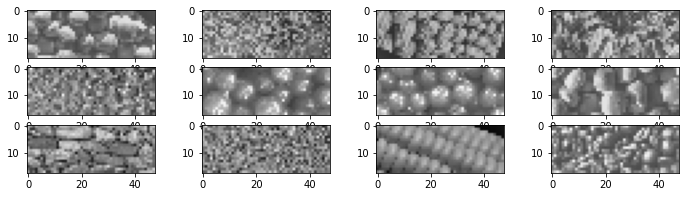

In [7]:
# display images
plt.figure(figsize=(12,3))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.reshape(Z[i,:], (Lyd, Lxd)), vmin=-3, vmax=3, cmap='gray')

## calculate receptive fields

We can map the stimuli data to the neural data using either linear regression or reduced rank regression to get the receptive fields of each neuron. 

The **get_rfs** function returns B0 (Ly x Lx x neuron matrix) and Spred (predicted spks based off the linear RF calculation).

In [8]:
from utils import get_rfs

# linear regression
B0, Spred = get_rfs(Z, spks, (18, 48), regression_type="linear")

In [9]:
Spred.shape

(100, 13860)

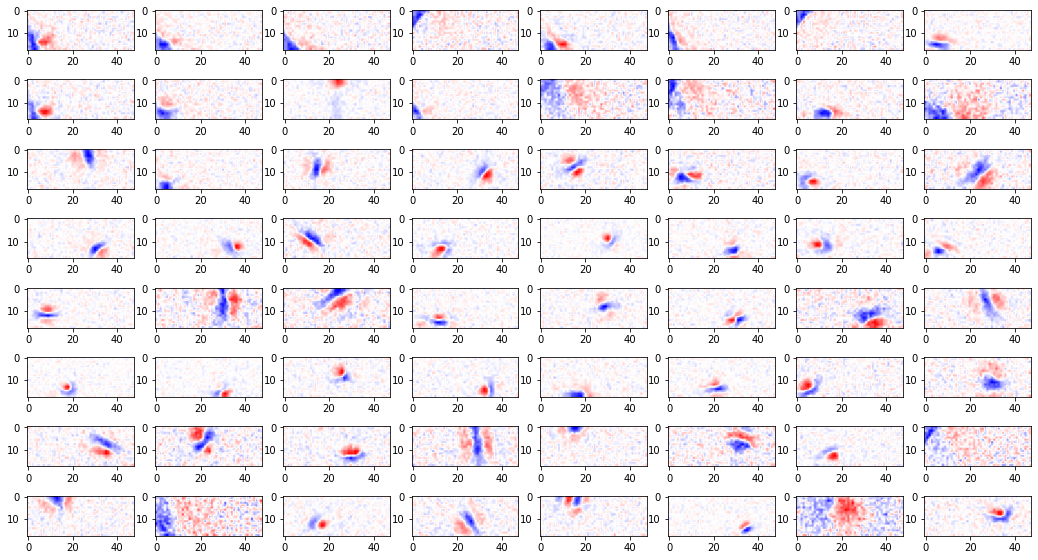

In [10]:
from utils import graph_RFs

# graph the best RFs (sorted by variance)

varexp = 1.0 - (Spred**2).mean(axis=-1)
asort = np.argsort(varexp)[::-1]
    
figure = graph_RFs(B0, asort)

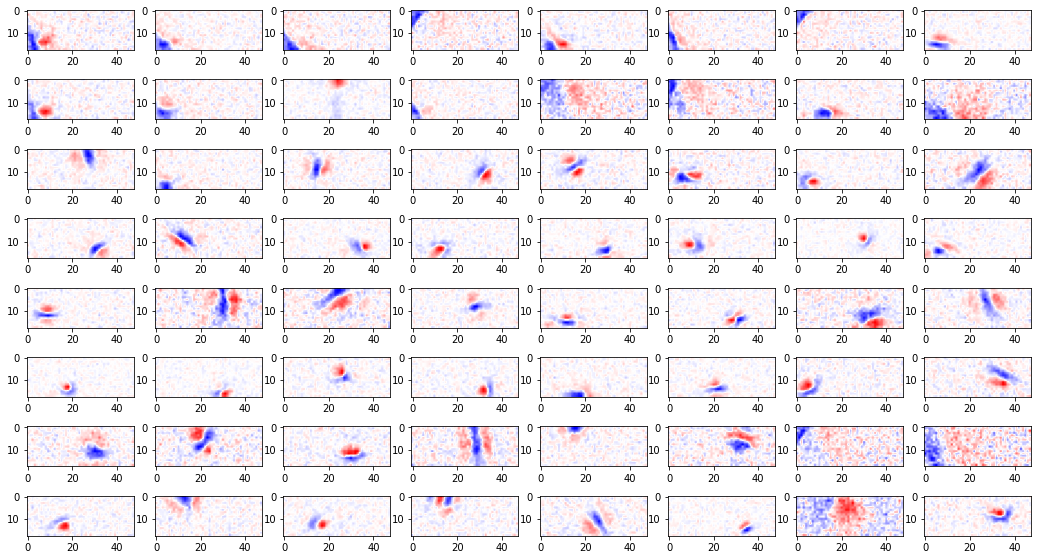

In [11]:
# reduced rank regression
B0, Spred = get_rfs(Z, spks, (18, 48), regression_type="reduced_rank")

varexp = 1.0 - (Spred**2).mean(axis=-1)
asort = np.argsort(varexp)[::-1]
    
figure = graph_RFs(B0, asort)

In [11]:
from utils import save_rf

In [17]:
import sys
sys.path.append("..")
save_rf(B0, Spred, "../sample_data/precomputed_rfs")

In [16]:
!pwd

/groups/stringer/home/josephs2/receptivefield-explorer/notebooks


In [20]:
import pickle
file_path = "../sample_data/precomputed_rfs"
dat = pickle.load(open(file_path, 'rb'))
B0, Spred = dat['B0'], dat['Spred']
del dat

In [22]:
B0.shape

(18, 48, 100)